# VGG-17: CIFAR-10 & PyTorch

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pickle

/home/arjun/anaconda3/envs/pytorch-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(f"torch version: {torch.__version__}")

torch version: 1.11.0


In [4]:
# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

Number of GPU(s) available = 1
Current GPU: 0
Current GPU name: NVIDIA GeForce RTX 3080


In [5]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cuda


In [6]:
# Specify hyper-parameters-
num_epochs = 80
batch_size = 256
learning_rate = 0.01

### CIFAR-10 data pre-processing

In [7]:
# Define transformations for training and test sets-
transform_train = transforms.Compose(
    [
        transforms.RandomCrop(32, padding = 4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4914, 0.4822, 0.4465),
            (0.2023, 0.1994, 0.2010)
        ),
    ]
)

transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4914, 0.4822, 0.4465),
            (0.2023, 0.1994, 0.2010)
        ),
    ]
)

In [8]:
# Load CIFAR-10 dataset-
train_dataset = torchvision.datasets.CIFAR10(
    root = './data', train = True,
    download = True, transform = transform_train
)

test_dataset = torchvision.datasets.CIFAR10(
    root = './data', train = False,
    download = True, transform = transform_test
)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
print(f"len(train_dataset) = {len(train_dataset)} & len(test_dataset) = {len(test_dataset)}")

len(train_dataset) = 50000 & len(test_dataset) = 10000


In [10]:
# Create training and testing loaders-
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_size,
    shuffle = True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size = batch_size,
    shuffle = True
)

In [11]:
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader) = 196 & len(test_loader) = 40


In [13]:
# Sanity check-
print(f"number of training steps in one epoch = {len(train_dataset) / batch_size}"
      f" & number of validation steps in 1 epoch = {len(test_dataset) / batch_size}")

number of training steps in one epoch = 195.3125 & number of validation steps in 1 epoch = 39.0625


In [14]:
# Sanity check-
images, labels = next(iter(train_loader))

images.size(), labels.shape

(torch.Size([256, 3, 32, 32]), torch.Size([256]))

In [15]:
# Unnormalize images-
images = images / 2 + 0.5
images = np.transpose(images.numpy(), (0, 2, 3, 1))

images.shape

(256, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

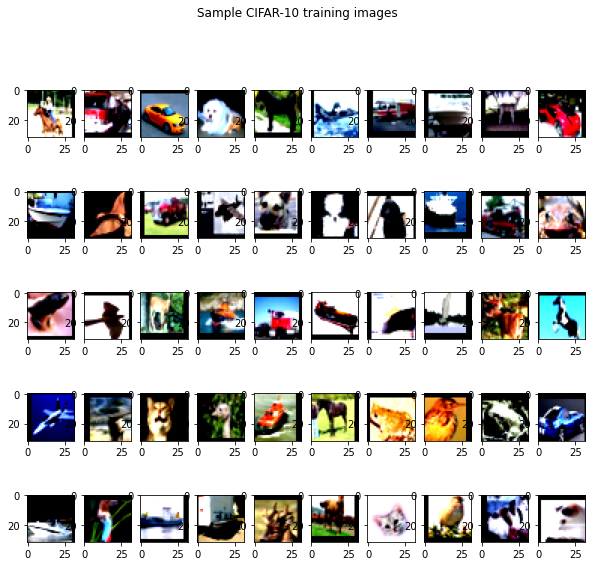

In [16]:
# Visualize 50 images from training set-
plt.figure(figsize = (10, 9))

for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.imshow(images[i])
    
plt.suptitle("Sample CIFAR-10 training images")
plt.show()

In [17]:
images.max(), images.min()

(1.8768656, -0.71453285)

In [18]:
del images, labels

### Define _VGG-17_ CNN architecture

In [19]:
class VGGBlock(nn.Module):
    '''
    VGG block within a VGG-* CNN model
    '''
    def __init__(self, input_channels, num_channels, padding_size = 1,
                 stride_size = 1, use_extra_conv = False, dropout = 0.2):
        super().__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels = input_channels, out_channels = num_channels,
            kernel_size = 3, padding = padding_size,
            stride = stride_size, bias = False
        )
        
        self.dropout = nn.Dropout(p = dropout)
        
        self.conv2 = nn.Conv2d(
            in_channels = num_channels, out_channels = num_channels,
            kernel_size = 3, padding = padding_size,
            stride = stride_size, bias = False
        )
        
        if use_extra_conv:
            self.conv3 = nn.Conv2d(
                in_channels = num_channels, out_channels = num_channels,
                kernel_size = 3, padding = padding_size,
                stride = stride_size, bias = False
            )
            
            self.conv4 = nn.Conv2d(
                in_channels = num_channels, out_channels = num_channels,
                kernel_size = 3, padding = padding_size,
                stride = stride_size, bias = False
            )
        else:
            self.conv3 = False
            self.conv4 = False
        
        self.pool = nn.MaxPool2d(
            kernel_size = 2, stride = 2)
            # padding = 1)
        
        self.bn1 = nn.BatchNorm2d(num_features = num_channels)
        self.bn2 = nn.BatchNorm2d(num_features = num_channels)

        if use_extra_conv:
            self.bn3 = nn.BatchNorm2d(num_features = num_channels)
            self.bn4 = nn.BatchNorm2d(num_features = num_channels)
        
        self.initialize_weights()
    
    
    def forward(self, X):
        Y = self.dropout(F.relu(self.bn1(self.conv1(X))))
        Y = self.dropout(F.relu(self.bn2(self.conv2(Y))))
        
        if self.conv3 and self.conv4:
            Y = self.dropout(F.relu(self.bn3(self.conv3(Y))))
            Y = self.dropout(F.relu(self.bn4(self.conv4(Y))))
            Y = self.pool(Y)
        else:
            Y = self.pool(Y)
        
        return Y
    
    
    def shape_computation(self, X):
        Y = self.bn1(self.conv1(X))
        print(f"self.bn(conv1(X)).shape: {Y.shape}")
        
        Y = self.bn2(self.conv2(Y))
        print(f"self.bn(conv2(Y)).shape: {Y.shape}")
        
        if self.conv3 and self.conv4:
            Y = self.bn3(self.conv3(Y))
            print(f"self.bn(conv3(Y)).shape: {Y.shape}")
            
            Y = self.bn4(self.conv4(Y))
            print(f"self.bn(conv4(Y)).shape: {Y.shape}")
            
            Y = self.pool(Y)
            print(f"self.pool(Y).shape: {Y.shape}")
        else:
            Y = self.pool(Y)
            print(f"self.pool(Y).shape: {Y.shape}")
        

    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)

                '''
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                '''
            
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
                

In [20]:
class VGG17(nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = VGGBlock(input_channels = 3, num_channels = 64, dropout = 0)
        self.block2 = VGGBlock(input_channels = 64, num_channels = 128)
        self.block3 = VGGBlock(input_channels = 128, num_channels = 256,
                use_extra_conv = True, dropout = 0.3)
        self.block4 = VGGBlock(input_channels = 256, num_channels = 512,
                use_extra_conv = True, dropout = 0.3)
        self.block5 = VGGBlock(input_channels = 512, num_channels = 512,
                use_extra_conv = True, dropout = 0.3)
        # self.pool = nn.AdaptiveAvgPool1d()
        self.flatten = nn.Flatten()
        self.output_layer = nn.Linear(in_features = 512, out_features = 10)
        
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        # x = self.pool(x)
        x = self.flatten(x)
        x = self.output_layer(x)
        return x
    

In [22]:
# Initialize VGG-17 architecture-
model = VGG17().to(device)

In [23]:
# Sanity check-
x, y = next(iter(train_loader))
x = x.to(device)
y = y.to(device)

In [24]:
x.shape, y.shape

(torch.Size([256, 3, 32, 32]), torch.Size([256]))

In [25]:
out = model(x)

In [26]:
out.shape, y.shape

(torch.Size([256, 10]), torch.Size([256]))

In [27]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

layer.shape = torch.Size([64, 3, 3, 3]) has 1728 parameters
layer.shape = torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([128, 64, 3, 3]) has 73728 parameters
layer.shape = torch.Size([128, 128, 3, 3]) has 147456 parameters
layer.shape = torch.Size([128]) has 128 parameters
layer.shape = torch.Size([128]) has 128 parameters
layer.shape = torch.Size([128]) has 128 parameters
layer.shape = torch.Size([128]) has 128 parameters
layer.shape = torch.Size([256, 128, 3, 3]) has 294912 parameters
layer.shape = torch.Size([256, 256, 3, 3]) has 589824 parameters
layer.shape = torch.Size([256, 256, 3, 3]) has 589824 parameters
layer.shape = torch.Size([256, 256, 3, 3]) has 589824 parameters
layer.shape = torch.Size([256]) has 256 parameters
layer.shape = torch.Size([256]) has 256

In [28]:
print(f"Total number of parameters in VGG-17 CNN = {tot_params}")

Total number of parameters in VGG-17 CNN = 20035018


In [ ]:
'''
# Print layer names-
for layer in model.state_dict().keys():
    print(f"{layer} has dimension = {model.state_dict()[layer].shape}")
'''

In [ ]:
# Save random initial weights-
torch.save(model.state_dict(), 'VGG18_random_weights_dropouts.pth')

In [ ]:
# Load randomly initialised weights-
# model.load_state_dict(torch.load('VGG18_random_weights_dropouts.pth'))

### Train _VGG-17_ CNN with _Initial learning rate warmup & step-decay_

- number of train images = 50K, batch-size = 256, number of train steps in 1 epoch = 50K / 256 = 195.3125 = 195 steps.

- Initial linear LR warmup: 195.3125 x 10 = 1953.125 steps. Or, 10 epochs from initial LR warmup = 0.0 to 0.1.

- Use LR = 0.1 until $35^{th}$ epoch. Or, use LR = 0.1 until 6835.9375 steps = 6836 steps.

- From $36^{th}$ until $50^{th}$ epochs use LR = 0.01. Or, until 9765.625 steps = 9766 steps.

- From $51^{st}$ until $70^{th}$ epochs use LR = 0.001. Or, until 13671.875 steps = 13672 steps.

- For remaining epochs, use LR = 0.0001.

In [37]:
boundaries = [6836, 9766, 13672]
values = [0.1, 0.01, 0.001, 0.0001]

In [38]:
# Define loss function and optimizer-
loss = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.0, momentum = 0.9, weight_decay = 5e-4)

In [39]:
# Sanity check-
optimizer.param_groups[0]['lr']

0.0

In [45]:
def decay_function(step, boundaries = [6836, 9766, 13672], values = [0.1, 0.01, 0.001, 0.0001]):
    '''
    One epoch has 195.3125 steps/iterations using batch size used above.
    
    Until 35th epochs, or 35 x 195.3125 = 6836 steps, use lr = 0.1
    From 36th epoch until 50th epoch, or 9766 steps use LR = 0.01
    From 51st epoch until 70th epoch or, 13672 steps use LR = 0.001
    For remaining epochs/steps LR = 0.0001
    '''
    
    for idx, bound in enumerate(boundaries):
        if step < bound:
            return values[idx]

    return values[-1]


In [46]:
class schedule():

    def __init__(self, initial_learning_rate = 0.1, warmup_steps = 1000, decay_func = None):
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.decay_func = decay_func
        self.warmup_step_size = initial_learning_rate/warmup_steps
        self.current_lr = 0

    def get_lr(self, step):
        if step == 0:
            return self.current_lr
        elif step <= self.warmup_steps:
            self.current_lr+=self.warmup_step_size
            return self.current_lr
        elif step > self.warmup_steps:
            if self.decay_func:
                return self.decay_func(step)
        else:
            return self.current_lr


In [47]:
# Initial linear LR warmup: 195.3125 x 10 = 1953.125 steps in 10 epochs.
custom_lr_scheduler = schedule(
    initial_learning_rate = 0.1, warmup_steps = 1953,
    decay_func = decay_function
)


In [48]:
step = 0

In [49]:
def train_model_progress(model, train_loader):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0
    
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = loss(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            global step
            optimizer.param_groups[0]['lr'] = custom_lr_scheduler.get_lr(step)

            step += 1
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.cpu().numpy()
    

In [50]:
def test_model_progress(model, test_loader):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                
                # Set model to evaluation mode-
                model.eval()
            
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.cpu().numpy()


In [51]:
# Python3 dict to contain training metrics-
training_history_lr_scheduler = {}

In [52]:
# Initialize parameters saving 'best' models-
best_val_loss = 100
loc_patience = 0

In [53]:
for epoch in range(num_epochs):

    # Train and validate model for 1 epoch-
    train_loss, train_acc = train_model_progress(model, train_loader)
    val_loss, val_acc = test_model_progress(model, test_loader)
    
    print(f"\nepoch: {epoch + 1} training loss = {train_loss:.4f}, "
          f"training accuracy = {train_acc:.2f}%, val_loss = {val_loss:.4f}"
          f", val_accuracy = {val_acc:.2f}% & "
          f"LR = {optimizer.param_groups[0]['lr']:.4f}\n")
    
    training_history_lr_scheduler[epoch + 1] = {
        'loss': train_loss, 'acc': train_acc,
        'val_loss': val_loss, 'val_acc': val_acc,
        'lr': optimizer.param_groups[0]['lr']
    }

    
    # Save best weights achieved until now-
    if (val_loss < best_val_loss):    
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = val_loss

        print(f"Saving model with lowest val_loss = {val_loss:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "VGG17_best_model.pth")
        

Validation: : 100%|███████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.99batch/s, val_acc=10, val_loss=3.07]



epoch: 1 training loss = 2.2345, training accuracy = 15.83%, val_loss = 3.0697, val_accuracy = 10.00% & LR = 0.0100

Saving model with lowest val_loss = 3.0697



Validation: : 100%|█████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.88batch/s, val_acc=14.6, val_loss=3.43]



epoch: 2 training loss = 1.8590, training accuracy = 26.70%, val_loss = 3.4272, val_accuracy = 14.59% & LR = 0.0200



Validation: : 100%|█████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.83batch/s, val_acc=13.2, val_loss=2.89]



epoch: 3 training loss = 1.6155, training accuracy = 37.36%, val_loss = 2.8894, val_accuracy = 13.19% & LR = 0.0301

Saving model with lowest val_loss = 2.8894



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.76batch/s, val_acc=34, val_loss=1.85]



epoch: 4 training loss = 1.3668, training accuracy = 49.09%, val_loss = 1.8484, val_accuracy = 33.95% & LR = 0.0401

Saving model with lowest val_loss = 1.8484



Validation: : 100%|█████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.80batch/s, val_acc=50.6, val_loss=1.43]



epoch: 5 training loss = 1.0980, training accuracy = 61.01%, val_loss = 1.4324, val_accuracy = 50.60% & LR = 0.0501

Saving model with lowest val_loss = 1.4324



Validation: : 100%|█████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.73batch/s, val_acc=59.5, val_loss=1.26]



epoch: 6 training loss = 0.9546, training accuracy = 66.54%, val_loss = 1.2605, val_accuracy = 59.50% & LR = 0.0602

Saving model with lowest val_loss = 1.2605



Validation: : 100%|█████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.71batch/s, val_acc=54.7, val_loss=1.39]



epoch: 7 training loss = 0.8560, training accuracy = 70.61%, val_loss = 1.3886, val_accuracy = 54.69% & LR = 0.0702



Validation: : 100%|█████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.77batch/s, val_acc=71.1, val_loss=1.01]



epoch: 8 training loss = 0.7816, training accuracy = 73.42%, val_loss = 1.0124, val_accuracy = 71.13% & LR = 0.0802

Saving model with lowest val_loss = 1.0124



Validation: : 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.75batch/s, val_acc=64.1, val_loss=1.1]



epoch: 9 training loss = 0.7388, training accuracy = 75.35%, val_loss = 1.0990, val_accuracy = 64.14% & LR = 0.0903



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.75batch/s, val_acc=69, val_loss=1.03]



epoch: 10 training loss = 0.6929, training accuracy = 77.09%, val_loss = 1.0262, val_accuracy = 69.02% & LR = 0.1000



Validation: : 100%|█████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.73batch/s, val_acc=65.2, val_loss=1.09]



epoch: 11 training loss = 0.6586, training accuracy = 78.26%, val_loss = 1.0863, val_accuracy = 65.16% & LR = 0.1000



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.69batch/s, val_acc=76.8, val_loss=0.801]



epoch: 12 training loss = 0.6142, training accuracy = 79.65%, val_loss = 0.8007, val_accuracy = 76.83% & LR = 0.1000

Saving model with lowest val_loss = 0.8007



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.59batch/s, val_acc=68.9, val_loss=1]



epoch: 13 training loss = 0.5772, training accuracy = 80.99%, val_loss = 1.0028, val_accuracy = 68.92% & LR = 0.1000



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.72batch/s, val_acc=77.3, val_loss=0.781]



epoch: 14 training loss = 0.5686, training accuracy = 81.29%, val_loss = 0.7813, val_accuracy = 77.32% & LR = 0.1000

Saving model with lowest val_loss = 0.7813



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.70batch/s, val_acc=76.4, val_loss=0.793]



epoch: 15 training loss = 0.5409, training accuracy = 82.31%, val_loss = 0.7925, val_accuracy = 76.39% & LR = 0.1000



Validation: : 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.67batch/s, val_acc=78, val_loss=0.795]



epoch: 16 training loss = 0.5219, training accuracy = 82.68%, val_loss = 0.7947, val_accuracy = 77.98% & LR = 0.1000



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.61batch/s, val_acc=71.1, val_loss=0.909]



epoch: 17 training loss = 0.5137, training accuracy = 83.10%, val_loss = 0.9088, val_accuracy = 71.14% & LR = 0.1000



Validation: : 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.59batch/s, val_acc=76.8, val_loss=0.8]



epoch: 18 training loss = 0.5056, training accuracy = 83.44%, val_loss = 0.8005, val_accuracy = 76.75% & LR = 0.1000



Validation: : 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.60batch/s, val_acc=78, val_loss=0.732]



epoch: 19 training loss = 0.4939, training accuracy = 83.81%, val_loss = 0.7316, val_accuracy = 78.02% & LR = 0.1000

Saving model with lowest val_loss = 0.7316



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.57batch/s, val_acc=80.5, val_loss=0.693]



epoch: 20 training loss = 0.4859, training accuracy = 84.12%, val_loss = 0.6930, val_accuracy = 80.46% & LR = 0.1000

Saving model with lowest val_loss = 0.6930



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.53batch/s, val_acc=76.5, val_loss=0.794]



epoch: 21 training loss = 0.4908, training accuracy = 83.92%, val_loss = 0.7939, val_accuracy = 76.46% & LR = 0.1000



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.52batch/s, val_acc=73.5, val_loss=0.797]



epoch: 22 training loss = 0.4641, training accuracy = 85.02%, val_loss = 0.7969, val_accuracy = 73.48% & LR = 0.1000



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.54batch/s, val_acc=69.1, val_loss=0.889]



epoch: 23 training loss = 0.4775, training accuracy = 84.45%, val_loss = 0.8887, val_accuracy = 69.10% & LR = 0.1000



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.56batch/s, val_acc=75.2, val_loss=0.774]



epoch: 24 training loss = 0.4671, training accuracy = 84.65%, val_loss = 0.7737, val_accuracy = 75.25% & LR = 0.1000



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.52batch/s, val_acc=79.6, val_loss=0.693]



epoch: 25 training loss = 0.4588, training accuracy = 85.04%, val_loss = 0.6935, val_accuracy = 79.56% & LR = 0.1000



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.61batch/s, val_acc=82.5, val_loss=0.625]



epoch: 26 training loss = 0.4589, training accuracy = 85.10%, val_loss = 0.6252, val_accuracy = 82.53% & LR = 0.1000

Saving model with lowest val_loss = 0.6252



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.64batch/s, val_acc=78.6, val_loss=0.687]



epoch: 27 training loss = 0.4481, training accuracy = 85.47%, val_loss = 0.6866, val_accuracy = 78.65% & LR = 0.1000



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.60batch/s, val_acc=81.4, val_loss=0.684]



epoch: 28 training loss = 0.4439, training accuracy = 85.53%, val_loss = 0.6838, val_accuracy = 81.42% & LR = 0.1000



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.46batch/s, val_acc=81.8, val_loss=0.673]



epoch: 29 training loss = 0.4397, training accuracy = 85.69%, val_loss = 0.6727, val_accuracy = 81.81% & LR = 0.1000



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.52batch/s, val_acc=75.6, val_loss=0.785]



epoch: 30 training loss = 0.4451, training accuracy = 85.44%, val_loss = 0.7846, val_accuracy = 75.65% & LR = 0.1000



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.50batch/s, val_acc=77.8, val_loss=0.708]



epoch: 31 training loss = 0.4440, training accuracy = 85.70%, val_loss = 0.7078, val_accuracy = 77.82% & LR = 0.1000



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.53batch/s, val_acc=83.8, val_loss=0.586]



epoch: 32 training loss = 0.4310, training accuracy = 86.03%, val_loss = 0.5860, val_accuracy = 83.79% & LR = 0.1000

Saving model with lowest val_loss = 0.5860



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.54batch/s, val_acc=80.5, val_loss=0.671]



epoch: 33 training loss = 0.4355, training accuracy = 85.83%, val_loss = 0.6714, val_accuracy = 80.51% & LR = 0.1000



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.56batch/s, val_acc=80.2, val_loss=0.663]



epoch: 34 training loss = 0.4442, training accuracy = 85.66%, val_loss = 0.6629, val_accuracy = 80.25% & LR = 0.1000



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.57batch/s, val_acc=87.7, val_loss=0.491]



epoch: 35 training loss = 0.4215, training accuracy = 86.35%, val_loss = 0.4911, val_accuracy = 87.72% & LR = 0.0100

Saving model with lowest val_loss = 0.4911



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.49batch/s, val_acc=90.5, val_loss=0.362]



epoch: 36 training loss = 0.2761, training accuracy = 90.96%, val_loss = 0.3619, val_accuracy = 90.50% & LR = 0.0100

Saving model with lowest val_loss = 0.3619



Validation: : 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.53batch/s, val_acc=91, val_loss=0.329]



epoch: 37 training loss = 0.2396, training accuracy = 92.06%, val_loss = 0.3288, val_accuracy = 90.99% & LR = 0.0100

Saving model with lowest val_loss = 0.3288



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.53batch/s, val_acc=90.7, val_loss=0.328]



epoch: 38 training loss = 0.2263, training accuracy = 92.40%, val_loss = 0.3284, val_accuracy = 90.68% & LR = 0.0100

Saving model with lowest val_loss = 0.3284



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.51batch/s, val_acc=91.1, val_loss=0.311]



epoch: 39 training loss = 0.2157, training accuracy = 92.88%, val_loss = 0.3110, val_accuracy = 91.07% & LR = 0.0100

Saving model with lowest val_loss = 0.3110



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.52batch/s, val_acc=91.5, val_loss=0.299]



epoch: 40 training loss = 0.2040, training accuracy = 93.32%, val_loss = 0.2993, val_accuracy = 91.55% & LR = 0.0100

Saving model with lowest val_loss = 0.2993



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.51batch/s, val_acc=91.2, val_loss=0.296]



epoch: 41 training loss = 0.1997, training accuracy = 93.37%, val_loss = 0.2961, val_accuracy = 91.19% & LR = 0.0100

Saving model with lowest val_loss = 0.2961



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.44batch/s, val_acc=92, val_loss=0.28]



epoch: 42 training loss = 0.1907, training accuracy = 93.64%, val_loss = 0.2802, val_accuracy = 92.02% & LR = 0.0100

Saving model with lowest val_loss = 0.2802



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.50batch/s, val_acc=91.3, val_loss=0.287]



epoch: 43 training loss = 0.1874, training accuracy = 93.72%, val_loss = 0.2868, val_accuracy = 91.35% & LR = 0.0100



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.55batch/s, val_acc=92, val_loss=0.27]



epoch: 44 training loss = 0.1782, training accuracy = 94.12%, val_loss = 0.2699, val_accuracy = 92.02% & LR = 0.0100

Saving model with lowest val_loss = 0.2699



Validation: : 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.49batch/s, val_acc=92, val_loss=0.269]



epoch: 45 training loss = 0.1764, training accuracy = 94.17%, val_loss = 0.2692, val_accuracy = 91.95% & LR = 0.0100

Saving model with lowest val_loss = 0.2692



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.52batch/s, val_acc=92, val_loss=0.27]



epoch: 46 training loss = 0.1680, training accuracy = 94.36%, val_loss = 0.2702, val_accuracy = 92.00% & LR = 0.0100



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.52batch/s, val_acc=91.5, val_loss=0.279]



epoch: 47 training loss = 0.1632, training accuracy = 94.53%, val_loss = 0.2790, val_accuracy = 91.49% & LR = 0.0100



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.50batch/s, val_acc=91.8, val_loss=0.268]



epoch: 48 training loss = 0.1636, training accuracy = 94.48%, val_loss = 0.2682, val_accuracy = 91.79% & LR = 0.0100

Saving model with lowest val_loss = 0.2682



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.51batch/s, val_acc=91.9, val_loss=0.264]



epoch: 49 training loss = 0.1584, training accuracy = 94.77%, val_loss = 0.2642, val_accuracy = 91.91% & LR = 0.0100

Saving model with lowest val_loss = 0.2642



Validation: : 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.49batch/s, val_acc=92, val_loss=0.258]



epoch: 50 training loss = 0.1572, training accuracy = 94.74%, val_loss = 0.2577, val_accuracy = 92.01% & LR = 0.0010

Saving model with lowest val_loss = 0.2577



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.49batch/s, val_acc=92.4, val_loss=0.249]



epoch: 51 training loss = 0.1369, training accuracy = 95.49%, val_loss = 0.2494, val_accuracy = 92.39% & LR = 0.0010

Saving model with lowest val_loss = 0.2494



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.33batch/s, val_acc=92.4, val_loss=0.248]



epoch: 52 training loss = 0.1352, training accuracy = 95.50%, val_loss = 0.2484, val_accuracy = 92.39% & LR = 0.0010

Saving model with lowest val_loss = 0.2484



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.50batch/s, val_acc=92.3, val_loss=0.248]



epoch: 53 training loss = 0.1322, training accuracy = 95.55%, val_loss = 0.2478, val_accuracy = 92.30% & LR = 0.0010

Saving model with lowest val_loss = 0.2478



Validation: : 100%|█████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.52batch/s, val_acc=92.5, val_loss=0.24]



epoch: 54 training loss = 0.1271, training accuracy = 95.77%, val_loss = 0.2404, val_accuracy = 92.48% & LR = 0.0010

Saving model with lowest val_loss = 0.2404



Validation: : 100%|█████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.49batch/s, val_acc=92.5, val_loss=0.24]



epoch: 55 training loss = 0.1288, training accuracy = 95.75%, val_loss = 0.2401, val_accuracy = 92.52% & LR = 0.0010

Saving model with lowest val_loss = 0.2401



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.55batch/s, val_acc=92.3, val_loss=0.242]



epoch: 56 training loss = 0.1254, training accuracy = 95.89%, val_loss = 0.2416, val_accuracy = 92.34% & LR = 0.0010



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.57batch/s, val_acc=92.3, val_loss=0.241]



epoch: 57 training loss = 0.1230, training accuracy = 95.83%, val_loss = 0.2410, val_accuracy = 92.30% & LR = 0.0010



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.59batch/s, val_acc=92.3, val_loss=0.242]



epoch: 58 training loss = 0.1226, training accuracy = 95.75%, val_loss = 0.2424, val_accuracy = 92.31% & LR = 0.0010



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.64batch/s, val_acc=92.4, val_loss=0.237]



epoch: 59 training loss = 0.1238, training accuracy = 95.77%, val_loss = 0.2373, val_accuracy = 92.38% & LR = 0.0010

Saving model with lowest val_loss = 0.2373



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.64batch/s, val_acc=92.4, val_loss=0.235]



epoch: 60 training loss = 0.1249, training accuracy = 95.78%, val_loss = 0.2352, val_accuracy = 92.41% & LR = 0.0010

Saving model with lowest val_loss = 0.2352



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.66batch/s, val_acc=92.3, val_loss=0.241]



epoch: 61 training loss = 0.1200, training accuracy = 95.97%, val_loss = 0.2405, val_accuracy = 92.27% & LR = 0.0010



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.62batch/s, val_acc=92.4, val_loss=0.238]



epoch: 62 training loss = 0.1208, training accuracy = 95.96%, val_loss = 0.2381, val_accuracy = 92.38% & LR = 0.0010



Validation: : 100%|█████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.61batch/s, val_acc=92.3, val_loss=0.24]



epoch: 63 training loss = 0.1211, training accuracy = 95.94%, val_loss = 0.2402, val_accuracy = 92.27% & LR = 0.0010



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.64batch/s, val_acc=92.4, val_loss=0.236]



epoch: 64 training loss = 0.1193, training accuracy = 96.08%, val_loss = 0.2358, val_accuracy = 92.38% & LR = 0.0010



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.63batch/s, val_acc=92.3, val_loss=0.239]



epoch: 65 training loss = 0.1196, training accuracy = 95.94%, val_loss = 0.2386, val_accuracy = 92.35% & LR = 0.0010



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.66batch/s, val_acc=92.4, val_loss=0.237]



epoch: 66 training loss = 0.1195, training accuracy = 95.94%, val_loss = 0.2366, val_accuracy = 92.42% & LR = 0.0010



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.63batch/s, val_acc=92.4, val_loss=0.235]



epoch: 67 training loss = 0.1161, training accuracy = 96.09%, val_loss = 0.2348, val_accuracy = 92.44% & LR = 0.0010

Saving model with lowest val_loss = 0.2348



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.64batch/s, val_acc=92.4, val_loss=0.235]



epoch: 68 training loss = 0.1187, training accuracy = 96.06%, val_loss = 0.2349, val_accuracy = 92.37% & LR = 0.0010



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.64batch/s, val_acc=92.4, val_loss=0.238]



epoch: 69 training loss = 0.1169, training accuracy = 96.09%, val_loss = 0.2376, val_accuracy = 92.44% & LR = 0.0010



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.64batch/s, val_acc=92.3, val_loss=0.237]



epoch: 70 training loss = 0.1144, training accuracy = 96.04%, val_loss = 0.2369, val_accuracy = 92.29% & LR = 0.0001



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.65batch/s, val_acc=92.3, val_loss=0.237]



epoch: 71 training loss = 0.1137, training accuracy = 96.10%, val_loss = 0.2368, val_accuracy = 92.34% & LR = 0.0001



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.61batch/s, val_acc=92.5, val_loss=0.231]



epoch: 72 training loss = 0.1113, training accuracy = 96.30%, val_loss = 0.2310, val_accuracy = 92.48% & LR = 0.0001

Saving model with lowest val_loss = 0.2310



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.64batch/s, val_acc=92.5, val_loss=0.234]



epoch: 73 training loss = 0.1163, training accuracy = 96.15%, val_loss = 0.2340, val_accuracy = 92.47% & LR = 0.0001



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.65batch/s, val_acc=92.4, val_loss=0.236]



epoch: 74 training loss = 0.1124, training accuracy = 96.20%, val_loss = 0.2361, val_accuracy = 92.39% & LR = 0.0001



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.66batch/s, val_acc=92.5, val_loss=0.232]



epoch: 75 training loss = 0.1156, training accuracy = 96.17%, val_loss = 0.2319, val_accuracy = 92.55% & LR = 0.0001



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.67batch/s, val_acc=92.5, val_loss=0.233]



epoch: 76 training loss = 0.1136, training accuracy = 96.10%, val_loss = 0.2332, val_accuracy = 92.50% & LR = 0.0001



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.63batch/s, val_acc=92.4, val_loss=0.236]



epoch: 77 training loss = 0.1134, training accuracy = 96.22%, val_loss = 0.2360, val_accuracy = 92.41% & LR = 0.0001



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.64batch/s, val_acc=92.3, val_loss=0.235]



epoch: 78 training loss = 0.1158, training accuracy = 96.13%, val_loss = 0.2355, val_accuracy = 92.34% & LR = 0.0001



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.64batch/s, val_acc=92.4, val_loss=0.235]



epoch: 79 training loss = 0.1120, training accuracy = 96.16%, val_loss = 0.2355, val_accuracy = 92.39% & LR = 0.0001



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.65batch/s, val_acc=92.5, val_loss=0.234]


epoch: 80 training loss = 0.1128, training accuracy = 96.27%, val_loss = 0.2340, val_accuracy = 92.46% & LR = 0.0001



In [54]:
print(f"Finished training VGG-17 CNN on CIFAR-10 dataset")

Finished training VGG-17 CNN on CIFAR-10 dataset


In [57]:
# Save model from last training epoch-
torch.save(model.state_dict(), "VGG17_last_epoch_model.pth")

In [56]:
# Save training metrics as Python3 history for later analysis-
with open("VGG17_training_history_lr_scheduler.pkl", "wb") as file:
    pickle.dump(training_history_lr_scheduler, file)

In [58]:
del model

In [59]:
# Initialize and load 'best' trained parameters from above-
best_trained_model = VGG17().to(device)
best_trained_model.load_state_dict(torch.load('VGG18_best_model.pth'))

<All keys matched successfully>

In [60]:
# Get validation loss and accuracy-
val_loss, val_acc = test_model_progress(best_trained_model, test_loader)

Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.26batch/s, val_acc=92.5, val_loss=0.231]


In [61]:
print(f"VGG-17 'best' model metrics: val_loss = {val_loss:.4f} & val_acc = {val_acc:.2f}%")

VGG-17 'best' model metrics: val_loss = 0.2310 & val_acc = 92.48%


In [ ]:
del best_trained_model

### VGG-17 training visualizations

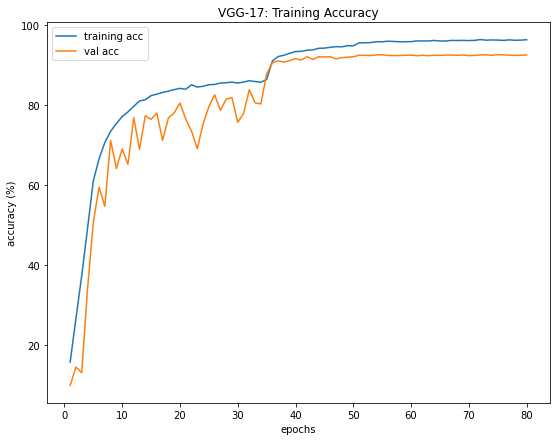

In [62]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['acc'] for k in training_history_lr_scheduler.keys()], label = 'training acc')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_acc'] for k in training_history_lr_scheduler.keys()], label = 'val acc')
plt.title("VGG-17: Training Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(loc = 'best')
plt.show()

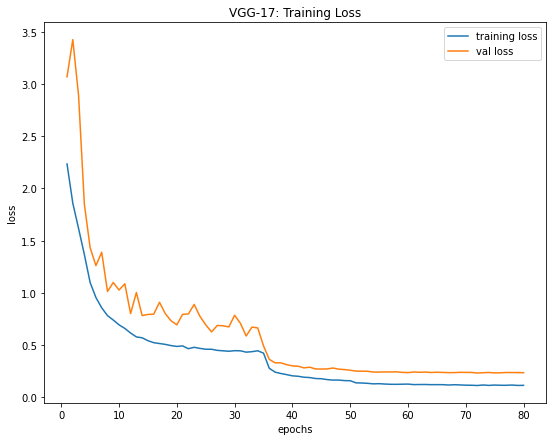

In [63]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['loss'] for k in training_history_lr_scheduler.keys()], label = 'training loss')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_loss'] for k in training_history_lr_scheduler.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("VGG-17: Training Loss")
plt.show()

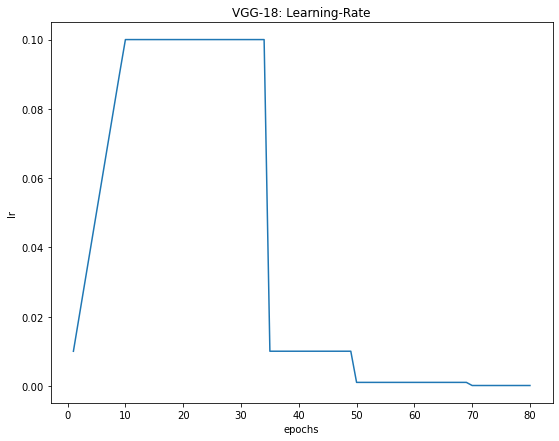

In [64]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['lr'] for k in training_history_lr_scheduler.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("VGG-18: Learning-Rate")
plt.show()